In [2]:
import tensorflow as tf
#import tensorflow.contrib.keras as keras
from pathlib import Path
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

import os
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


print("Done with library declaration, Current version of Tensorflow is: ", tf.__version__)

Done with library declaration, Current version of Tensorflow is:  2.16.1


In [3]:
class_names = ["aluminem_cans", "cardboard", "food", "generic_trash", "glass_bottle", "hazardous_waste", "medical_waste", "paper", "plastic_bottle", "plastic_not_recylable", "plastic_recylable"]

image_root_path = Path("data_organized")
train_root_path = image_root_path / "train"
test_root_path = image_root_path / "test"


os.makedirs(train_root_path, exist_ok=True)
os.makedirs(test_root_path, exist_ok=True)

train_count = 0
test_count = 0
for class_name in class_names:
    imagepath = image_root_path / class_name
    train_graypath = train_root_path / class_name
    test_graypath = test_root_path / class_name
  
    os.makedirs(train_graypath, exist_ok=True)
    os.makedirs(test_graypath, exist_ok=True)
 
    file_list = os.listdir(imagepath)
    num_files_train = int(len(file_list) * 0.8)
    num_files_test = len(file_list) - num_files_train
    test_files = random.sample(file_list, num_files_test)

    for file in file_list:
        img_path = imagepath / file
        if file in test_files:
            gray_path = test_graypath / file
            test_count += 1
        else:
            gray_path = train_graypath / file
            train_count += 1
        im = Image.open(img_path)
        img = im.resize((32, 32))
        gray = img.convert('L')
        gray.save(gray_path, "JPEG")
        
print(test_count)
print(train_count)

1970
7864


In [4]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32,32, 1)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(11, activation='softmax')
])



/Users/yvongatete/4700Prac/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
batch_size = 45
epochs = 60
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,947 (187.29 KB)

 Trainable params: 47,947 (187.29 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)


train_generator = train_gen.flow_from_directory(
    train_root_path,
    target_size=(32, 32),
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_gen.flow_from_directory(
    test_root_path,
    target_size=(32, 32),
    color_mode='grayscale',
    class_mode='categorical'
)


batch_size = 32
epochs = 60
steps_per_epoch = train_count // batch_size
validation_steps = test_count // batch_size





early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=7)


history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    # validation_steps=validation_steps
    # callbacks=[early_stopping]
)


test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy: {} Test Loss: {} '.format(test_acc*100, test_loss))







Found 7861 images belonging to 11 classes.
Found 1970 images belonging to 11 classes.
Epoch 1/60
  7/245 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.2501 - loss: 2.3400      

/Users/yvongatete/4700Prac/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4330 - loss: 1.8994 - val_accuracy: 0.5350 - val_loss: 1.5507
Epoch 2/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4375 - loss: 1.9212

2024-05-17 17:13:33.800986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/yvongatete/.pyenv/versions/3.12.2/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4375 - loss: 1.9212 - val_accuracy: 0.5213 - val_loss: 1.5698
Epoch 3/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5137 - loss: 1.5648 - val_accuracy: 0.5299 - val_loss: 1.4825
Epoch 4/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4688 - loss: 1.6118

2024-05-17 17:13:37.633119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4688 - loss: 1.6118 - val_accuracy: 0.5381 - val_loss: 1.4674
Epoch 5/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5421 - loss: 1.4407 - val_accuracy: 0.5782 - val_loss: 1.3699
Epoch 6/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5938 - loss: 1.0829

2024-05-17 17:13:41.579206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 1.0829 - val_accuracy: 0.5802 - val_loss: 1.3744
Epoch 7/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5748 - loss: 1.3608 - val_accuracy: 0.5802 - val_loss: 1.3371
Epoch 8/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5000 - loss: 1.5956

2024-05-17 17:13:45.294359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 1.5956 - val_accuracy: 0.5751 - val_loss: 1.3388
Epoch 9/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5869 - loss: 1.2729 - val_accuracy: 0.5761 - val_loss: 1.3216
Epoch 10/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6875 - loss: 0.9797

2024-05-17 17:13:49.184948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.9797 - val_accuracy: 0.5726 - val_loss: 1.3275
Epoch 11/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6024 - loss: 1.2595 - val_accuracy: 0.5838 - val_loss: 1.3392
Epoch 12/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5938 - loss: 1.1366

2024-05-17 17:13:53.242969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 1.1366 - val_accuracy: 0.5893 - val_loss: 1.3119
Epoch 13/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6031 - loss: 1.2202 - val_accuracy: 0.5934 - val_loss: 1.2849
Epoch 14/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6562 - loss: 1.0740

2024-05-17 17:13:57.369553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 1.0740 - val_accuracy: 0.5929 - val_loss: 1.2940
Epoch 15/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6226 - loss: 1.1590 - val_accuracy: 0.5822 - val_loss: 1.3020
Epoch 16/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5938 - loss: 1.1991

2024-05-17 17:14:01.639309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 1.1991 - val_accuracy: 0.5919 - val_loss: 1.2869
Epoch 17/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6266 - loss: 1.1377 - val_accuracy: 0.5954 - val_loss: 1.2632
Epoch 18/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5938 - loss: 1.2687

2024-05-17 17:14:05.707708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 1.2687 - val_accuracy: 0.5954 - val_loss: 1.2692
Epoch 19/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6345 - loss: 1.1202 - val_accuracy: 0.5888 - val_loss: 1.2946
Epoch 20/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6875 - loss: 1.0351

2024-05-17 17:14:09.680220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 1.0351 - val_accuracy: 0.5934 - val_loss: 1.2928
Epoch 21/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6351 - loss: 1.1025 - val_accuracy: 0.6086 - val_loss: 1.2411
Epoch 22/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5625 - loss: 1.3239

2024-05-17 17:14:13.948852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 1.3239 - val_accuracy: 0.5985 - val_loss: 1.2577
Epoch 23/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6608 - loss: 1.0208 - val_accuracy: 0.6127 - val_loss: 1.2566
Epoch 24/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7188 - loss: 0.6863

2024-05-17 17:14:18.065460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.6863 - val_accuracy: 0.6162 - val_loss: 1.2371
Epoch 25/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6711 - loss: 0.9838 - val_accuracy: 0.6239 - val_loss: 1.2242
Epoch 26/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6875 - loss: 0.9203

2024-05-17 17:14:22.352126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.9203 - val_accuracy: 0.6254 - val_loss: 1.2214
Epoch 27/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6755 - loss: 0.9741 - val_accuracy: 0.6081 - val_loss: 1.3224
Epoch 28/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6875 - loss: 1.0066

2024-05-17 17:14:26.614728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 1.0066 - val_accuracy: 0.6132 - val_loss: 1.3209
Epoch 29/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6860 - loss: 0.9432 - val_accuracy: 0.5954 - val_loss: 1.2966
Epoch 30/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6562 - loss: 1.0936

2024-05-17 17:14:30.782509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 1.0936 - val_accuracy: 0.6086 - val_loss: 1.2790
Epoch 31/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6939 - loss: 0.9060 - val_accuracy: 0.6142 - val_loss: 1.2466
Epoch 32/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8438 - loss: 0.5551

2024-05-17 17:14:34.943796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.5551 - val_accuracy: 0.6137 - val_loss: 1.2432
Epoch 33/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7164 - loss: 0.8460 - val_accuracy: 0.6142 - val_loss: 1.3020
Epoch 34/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6875 - loss: 1.0331

2024-05-17 17:14:39.355544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 1.0331 - val_accuracy: 0.6162 - val_loss: 1.2854
Epoch 35/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7244 - loss: 0.8196 - val_accuracy: 0.5975 - val_loss: 1.2919
Epoch 36/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8438 - loss: 0.5869

2024-05-17 17:14:43.765067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.5869 - val_accuracy: 0.5919 - val_loss: 1.3102
Epoch 37/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7407 - loss: 0.7762 - val_accuracy: 0.6168 - val_loss: 1.2916
Epoch 38/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7188 - loss: 0.9741

2024-05-17 17:14:47.992092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.9741 - val_accuracy: 0.6162 - val_loss: 1.2910
Epoch 39/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7637 - loss: 0.7042 - val_accuracy: 0.6142 - val_loss: 1.3683
Epoch 40/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7188 - loss: 1.0424

2024-05-17 17:14:51.874413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 1.0424 - val_accuracy: 0.6142 - val_loss: 1.3418
Epoch 41/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7631 - loss: 0.7084 - val_accuracy: 0.6030 - val_loss: 1.3609
Epoch 42/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8438 - loss: 0.6930

2024-05-17 17:14:55.849441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.6930 - val_accuracy: 0.5990 - val_loss: 1.3455
Epoch 43/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7802 - loss: 0.6535 - val_accuracy: 0.6188 - val_loss: 1.3728
Epoch 44/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8750 - loss: 0.6970

2024-05-17 17:14:59.704618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.6970 - val_accuracy: 0.6132 - val_loss: 1.3708
Epoch 45/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7960 - loss: 0.6306 - val_accuracy: 0.6112 - val_loss: 1.4187
Epoch 46/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7188 - loss: 0.7289

2024-05-17 17:15:03.955838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.7289 - val_accuracy: 0.6112 - val_loss: 1.4108
Epoch 47/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7963 - loss: 0.6085 - val_accuracy: 0.6041 - val_loss: 1.4473
Epoch 48/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6562 - loss: 1.0644

2024-05-17 17:15:08.015293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 1.0644 - val_accuracy: 0.6015 - val_loss: 1.4413
Epoch 49/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8168 - loss: 0.5711 - val_accuracy: 0.6188 - val_loss: 1.4907
Epoch 50/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7812 - loss: 0.6802

2024-05-17 17:15:12.170246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.6802 - val_accuracy: 0.6183 - val_loss: 1.4859
Epoch 51/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8208 - loss: 0.5521 - val_accuracy: 0.6046 - val_loss: 1.5195
Epoch 52/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7188 - loss: 0.6372

2024-05-17 17:15:16.473741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.6372 - val_accuracy: 0.5985 - val_loss: 1.5349
Epoch 53/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8276 - loss: 0.5221 - val_accuracy: 0.6137 - val_loss: 1.5887
Epoch 54/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7500 - loss: 0.6862

2024-05-17 17:15:20.997397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.6862 - val_accuracy: 0.6122 - val_loss: 1.5936
Epoch 55/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8446 - loss: 0.4842 - val_accuracy: 0.5975 - val_loss: 1.5896
Epoch 56/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8750 - loss: 0.3543

2024-05-17 17:15:25.223297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.3543 - val_accuracy: 0.5970 - val_loss: 1.5942
Epoch 57/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8511 - loss: 0.4657 - val_accuracy: 0.5807 - val_loss: 1.6463
Epoch 58/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8125 - loss: 0.4697

2024-05-17 17:15:29.497395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.4697 - val_accuracy: 0.5787 - val_loss: 1.6552
Epoch 59/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8566 - loss: 0.4314 - val_accuracy: 0.5934 - val_loss: 1.6681
Epoch 60/60
  1/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7812 - loss: 0.6862

2024-05-17 17:15:33.608436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.6862 - val_accuracy: 0.5949 - val_loss: 1.6681
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6137 - loss: 1.6234
Test accuracy: 59.492385387420654 Test Loss: 1.6681092977523804 


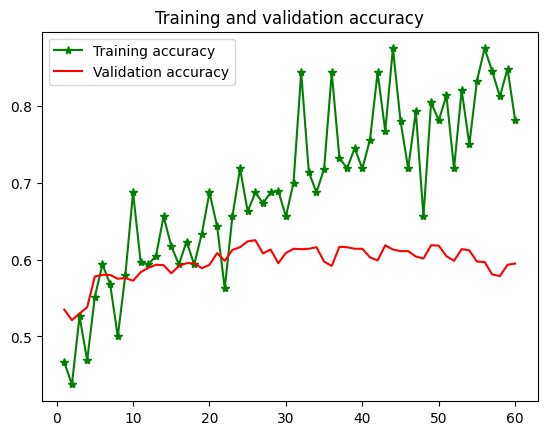

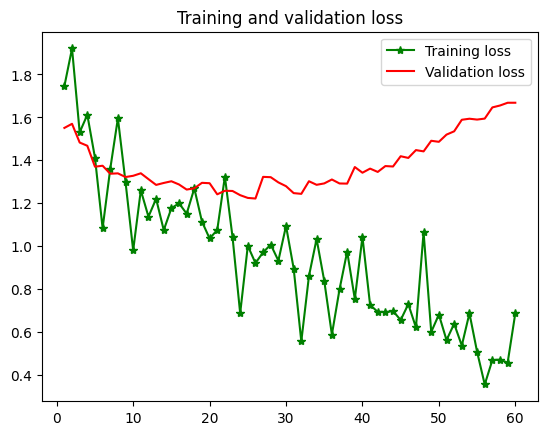

In [7]:
train_acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
train_loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()